In [100]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 11.5 MB/s eta 0:00:001m11.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 2.1 MB/s eta 0:00:001 MB/s eta 0:00:01


In [102]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.6/628.6 kB 5.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s eta 0:00:00 MB/s eta 0:00:01


In [243]:
import yfinance as yf
import pandas as pd

from tqdm import tqdm

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get the list of NASDAQ companies
nasdaq_tickers = pd.read_csv('../raw_data/nasdaq_tickers_raw.csv')
#nasdaq_tickers= pd.read_csv('https://datahub.io/core/nasdaq-listings/r/nasdaq-listed-symbols.csv')
tickers_total = nasdaq_tickers['Symbol'].tolist()
tickers_small = tickers_total[0:200]
len(tickers_total)

7133

In [19]:
msft = yf.Ticker("MSFT")

# get all stock info
msft.info

# get historical market data
hist = msft.history(period="5y")
hist = hist.reset_index()
hist_2 = hist[["Date", "Close"]]
msft_df = hist_2.set_index("Date").rename(columns={"Close": msft.ticker})
msft_df


,MSFT
Date,
2019-06-03 00:00:00-04:00,114.290886
2019-06-04 00:00:00-04:00,117.457176
2019-06-05 00:00:00-04:00,120.003517
2019-06-06 00:00:00-04:00,121.901382
2019-06-07 00:00:00-04:00,125.315636
...,...
2024-05-24 00:00:00-04:00,430.160004
2024-05-28 00:00:00-04:00,430.320007
2024-05-29 00:00:00-04:00,429.170013


In [20]:


apple = yf.Ticker("AAPL")

# get all stock info
#msft.info

# get historical market data
hist = apple.history(period="5y")
hist = hist.reset_index()
hist_2 = hist[["Date", "Close"]]
apple_df = hist_2.set_index("Date").rename(columns={"Close": apple.ticker})
apple_df


,AAPL
Date,
2019-06-03 00:00:00-04:00,41.812840
2019-06-04 00:00:00-04:00,43.342510
2019-06-05 00:00:00-04:00,44.042213
2019-06-06 00:00:00-04:00,44.688820
2019-06-07 00:00:00-04:00,45.878307
...,...
2024-05-24 00:00:00-04:00,189.979996
2024-05-28 00:00:00-04:00,189.990005
2024-05-29 00:00:00-04:00,190.289993


In [21]:
msft_df.join(apple_df, how="left")

,MSFT,AAPL
Date,,
2019-06-03 00:00:00-04:00,114.290886,41.812840
2019-06-04 00:00:00-04:00,117.457176,43.342510
2019-06-05 00:00:00-04:00,120.003517,44.042213
2019-06-06 00:00:00-04:00,121.901382,44.688820
2019-06-07 00:00:00-04:00,125.315636,45.878307
...,...,...
2024-05-24 00:00:00-04:00,430.160004,189.979996
2024-05-28 00:00:00-04:00,430.320007,189.990005
2024-05-29 00:00:00-04:00,429.170013,190.289993


In [22]:
tickers_total[0]

'A'

In [59]:
#initialize DataFrame
first_company = yf.Ticker("A")

# get historical market data
hist = first_company.history(period="5y")
hist = hist.reset_index()
hist_2 = hist[["Date", "Close"]]
df = hist_2.set_index("Date").rename(columns={"Close": first_company.ticker})
df

,A
Date,
2019-06-03 00:00:00-04:00,64.663116
2019-06-04 00:00:00-04:00,65.589783
2019-06-05 00:00:00-04:00,65.975883
2019-06-06 00:00:00-04:00,66.757751
2019-06-07 00:00:00-04:00,67.105247
...,...
2024-05-24 00:00:00-04:00,150.660004
2024-05-28 00:00:00-04:00,148.210007
2024-05-29 00:00:00-04:00,145.479996


In [40]:
%%time
#Loop


for company in tickers_total: 
    company_ticker = yf.Ticker(company)
    
    # get historical market data
    hist = company_ticker.history(period="5y")
    hist = hist.reset_index()
    hist_2 = hist[["Date", "Close"]]
    company_df = hist_2.set_index("Date").rename(columns={"Close": company_ticker.ticker})
    df = df.join(company_df, how="left")
    

AACIW: Period '5y' is invalid, must be one of ['1d', '5d']
AACT: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']
AAGRW: Period '5y' is invalid, must be one of ['1d', '5d']
ABLLL: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']
ABLLW: Period '5y' is invalid, must be one of ['1d', '5d']
ABLV: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']
ABR^D: No data found, symbol may be delisted
ABR^E: No data found, symbol may be delisted
ABR^F: No data found, symbol may be delisted
ABVX: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']
ACAC: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
ACONW: Period '5y' is invalid, must be one of ['1d', '5d']
ACP^A: No data found, symbol may be delisted
ACR^C: No data found, symbol may be delisted
ACR^D: No data found, symbol may be d

CPU times: user 4.48 s, sys: 202 ms, total: 4.68 s
Wall time: 24.1 s


In [65]:
%%time

for company in tqdm (tickers_total[4348: ], desc="Loading…", ascii=False, ncols=75):
    company_ticker = yf.Ticker(company)
    
    # get historical market data
    hist = company_ticker.history(period="5y")
    hist = hist.reset_index()
    hist_2 = hist[["Date", "Close"]]
    company_df = hist_2.set_index("Date").rename(columns={"Close": company_ticker.ticker})
    df = df.join(company_df, how="left")
    
    #time.sleep(0.01)
     
print("Complete.")

Loading…:   1%|▎                         | 35/2785 [00:05<07:20,  6.24it/s]NCDL: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
NCI: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']
Loading…:   1%|▍                         | 41/2785 [00:06<06:15,  7.30it/s]NCNC: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', 'ytd', 'max']
NCNCW: Period '5y' is invalid, must be one of ['1d', '5d']
Loading…:   3%|▋                         | 77/2785 [00:17<05:22,  8.40it/s]NETDU: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']
NETDW: Period '5y' is invalid, must be one of ['1d', '5d']
Loading…:   6%|█▍                       | 161/2785 [00:35<05:50,  7.48it/s]NNAG: Period '5y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', '1y', 'ytd', 'max']
NNAGR: Period '5y' is invalid, must be one of ['1d', '5d']
Loading…:   6%|█▍                       |

Complete.
CPU times: user 1min 50s, sys: 55.3 s, total: 2min 46s
Wall time: 10min 22s


In [64]:
df_first = df.copy()
df_first

,A,AA,AACG,AACI,AACIW,AACT,AADI,AAGR,AAGRW,AAL,...,MYN,MYNA,MYND,MYNZ,MYO,MYPS,MYPSW,MYRG,MYSZ,MYTE
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-03 00:00:00-04:00,64.663116,20.927528,1.80,NaN,NaN,NaN,15.600,NaN,NaN,26.917612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,NaN,NaN,NaN,15.600,NaN,NaN,28.817680,...,11.218951,NaN,66.400002,NaN,26.730000,NaN,NaN,33.619999,2085.00,NaN
2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,NaN,NaN,NaN,15.000,NaN,NaN,30.044806,...,11.201199,NaN,64.900002,NaN,27.000000,NaN,NaN,33.340000,2010.00,NaN
2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,NaN,NaN,NaN,15.000,NaN,NaN,30.064596,...,11.183451,NaN,65.099998,NaN,25.559999,NaN,NaN,33.020000,1956.00,NaN
2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,NaN,NaN,NaN,15.000,NaN,NaN,30.598991,...,11.272205,NaN,66.300003,NaN,25.139999,NaN,NaN,33.500000,1977.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,11.460,NaN,NaN,1.840,0.378,NaN,13.840000,...,10.380000,4.78,2.944000,0.572,3.830000,2.31,0.051,159.320007,3.85,5.29
2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,11.370,NaN,NaN,1.880,0.399,NaN,13.440000,...,10.290000,4.54,2.700000,0.760,3.620000,2.29,0.056,156.929993,3.56,5.46
2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,11.364,NaN,NaN,1.760,0.400,NaN,11.620000,...,10.200000,4.51,2.610000,0.740,3.490000,2.23,0.050,157.210007,3.45,5.34


In [72]:
df.to_csv("../raw_data/raw_data_stock_market_4y_fortimeseries.csv")

In [81]:
df

,Date,A,AA,AACG,AADI,AAL,AAME,AAN,AAOI,AAON,...,ZTEK,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVRA,ZWS,ZYME,ZYXI
0,2019-06-03 00:00:00-04:00,64.663116,20.927528,1.80,15.600,26.917612,2.298342,NaN,8.81,29.745047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,15.600,28.817680,2.298342,NaN,9.19,31.003340,...,0.27,17.606050,8.710528,106.453125,20.650000,14.30,24.799999,27.959999,19.080000,6.636364
2,2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,15.000,30.044806,2.298342,NaN,9.23,31.184948,...,0.28,17.066587,8.702794,106.827278,19.940001,14.18,24.000000,28.120001,19.610001,7.245455
3,2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,15.000,30.064596,2.375923,NaN,9.30,31.249809,...,0.28,16.939081,8.741472,107.211266,18.670000,14.57,23.520000,28.120001,19.990000,7.690909
4,2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,15.000,30.598991,2.375923,NaN,9.50,31.684376,...,0.26,17.223522,8.803359,108.363228,21.650000,14.56,22.559999,28.110001,20.930000,7.918182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,1.840,13.840000,1.650000,7.21,12.54,78.260002,...,1.08,24.080000,5.400000,170.070007,18.400000,9.97,4.660000,31.950001,8.720000,10.520000
1255,2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,1.880,13.440000,1.630000,7.09,12.38,77.680000,...,1.10,24.660000,5.350000,171.300003,18.940001,9.57,4.560000,31.290001,8.710000,10.110000
1256,2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,1.760,11.620000,1.640000,7.23,11.98,74.870003,...,1.11,24.049999,5.270000,170.800003,19.049999,9.72,4.595000,30.459999,8.480000,10.020000
1257,2024-05-30 00:00:00-04:00,131.419998,44.540001,0.90,1.735,11.440000,1.660000,7.71,11.59,74.930000,...,1.11,23.860001,5.340000,169.440002,18.950001,9.71,4.670000,31.080000,8.430000,9.920000


In [79]:
df = df.reset_index()
df

,Date,A,AA,AACG,AADI,AAL,AAME,AAN,AAOI,AAON,...,ZTEK,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVRA,ZWS,ZYME,ZYXI
0,2019-06-03 00:00:00-04:00,64.663116,20.927528,1.80,15.600,26.917612,2.298342,NaN,8.81,29.745047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,15.600,28.817680,2.298342,NaN,9.19,31.003340,...,0.27,17.606050,8.710528,106.453125,20.650000,14.30,24.799999,27.959999,19.080000,6.636364
2,2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,15.000,30.044806,2.298342,NaN,9.23,31.184948,...,0.28,17.066587,8.702794,106.827278,19.940001,14.18,24.000000,28.120001,19.610001,7.245455
3,2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,15.000,30.064596,2.375923,NaN,9.30,31.249809,...,0.28,16.939081,8.741472,107.211266,18.670000,14.57,23.520000,28.120001,19.990000,7.690909
4,2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,15.000,30.598991,2.375923,NaN,9.50,31.684376,...,0.26,17.223522,8.803359,108.363228,21.650000,14.56,22.559999,28.110001,20.930000,7.918182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,1.840,13.840000,1.650000,7.21,12.54,78.260002,...,1.08,24.080000,5.400000,170.070007,18.400000,9.97,4.660000,31.950001,8.720000,10.520000
1255,2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,1.880,13.440000,1.630000,7.09,12.38,77.680000,...,1.10,24.660000,5.350000,171.300003,18.940001,9.57,4.560000,31.290001,8.710000,10.110000
1256,2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,1.760,11.620000,1.640000,7.23,11.98,74.870003,...,1.11,24.049999,5.270000,170.800003,19.049999,9.72,4.595000,30.459999,8.480000,10.020000
1257,2024-05-30 00:00:00-04:00,131.419998,44.540001,0.90,1.735,11.440000,1.660000,7.71,11.59,74.930000,...,1.11,23.860001,5.340000,169.440002,18.950001,9.71,4.670000,31.080000,8.430000,9.920000


In [94]:
#Imports
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer

#CLEANING THE DATA:

#drop columns that have more than 30% of missing data:
def remove_shitty_columns(df):
    for column in df.columns:
        if df[column].isnull().sum()/len(df) > 0.01:
            df.drop(columns=[column], inplace=True)
    return df


#drop rows that have more than 30% of missing values
def remove_shitty_rows(df):
    threshold = 0.3 * df.shape[1]  # Calculate the threshold for missing values
    df = df.dropna(thresh=int(df.shape[1] - threshold))
    return df

#FINAL CLEANING FUNCTION
def clean_dataframe(df):
    df = remove_shitty_columns(df)
    df = remove_shitty_rows(df)
    df = df.reset_index(drop=True)
    return df


#PREPROCESSING
def preprocessing_the_data(df):
    #use simple impute with strategy = "constant"
    imputer = SimpleImputer(strategy="constant", fill_value=0)

    #Robust Scaler to Scale data because of outliers
    rb_scaler = RobustScaler()

    #select numerical columns
    num_transformer = make_pipeline(imputer, rb_scaler)
    num_columns = make_column_selector(dtype_exclude="object")

    #Create Preproc Pipeline
    preproc_basic = make_column_transformer((num_transformer, num_columns))

    #Apply Preprocessing to dataframe
    preprocessed_data = preproc_basic.fit_transform(df)

    #Change column names of transformed dataframe
    df_preproc = pd.DataFrame(preprocessed_data, columns=preproc_basic.get_feature_names_out())

    #Merge with tickers
    df_preproc = df_preproc.join(df.Ticker)

    return df_preproc





In [80]:
df_clean = clean_dataframe(df)
df_clean

,Date,A,AA,AACG,AADI,AAL,AAME,AAN,AAOI,AAON,...,ZTEK,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVRA,ZWS,ZYME,ZYXI
0,2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,15.600,28.817680,2.298342,NaN,9.19,31.003340,...,0.27,17.606050,8.710528,106.453125,20.650000,14.30,24.799999,27.959999,19.080000,6.636364
1,2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,15.000,30.044806,2.298342,NaN,9.23,31.184948,...,0.28,17.066587,8.702794,106.827278,19.940001,14.18,24.000000,28.120001,19.610001,7.245455
2,2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,15.000,30.064596,2.375923,NaN,9.30,31.249809,...,0.28,16.939081,8.741472,107.211266,18.670000,14.57,23.520000,28.120001,19.990000,7.690909
3,2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,15.000,30.598991,2.375923,NaN,9.50,31.684376,...,0.26,17.223522,8.803359,108.363228,21.650000,14.56,22.559999,28.110001,20.930000,7.918182
4,2019-06-10 00:00:00-04:00,67.848526,20.995630,2.19,14.700,30.440655,2.375923,NaN,9.60,31.548170,...,0.26,17.596243,8.772415,108.520767,21.459999,14.76,22.400000,28.709999,20.680000,7.663636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,1.840,13.840000,1.650000,7.21,12.54,78.260002,...,1.08,24.080000,5.400000,170.070007,18.400000,9.97,4.660000,31.950001,8.720000,10.520000
1254,2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,1.880,13.440000,1.630000,7.09,12.38,77.680000,...,1.10,24.660000,5.350000,171.300003,18.940001,9.57,4.560000,31.290001,8.710000,10.110000
1255,2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,1.760,11.620000,1.640000,7.23,11.98,74.870003,...,1.11,24.049999,5.270000,170.800003,19.049999,9.72,4.595000,30.459999,8.480000,10.020000
1256,2024-05-30 00:00:00-04:00,131.419998,44.540001,0.90,1.735,11.440000,1.660000,7.71,11.59,74.930000,...,1.11,23.860001,5.340000,169.440002,18.950001,9.71,4.670000,31.080000,8.430000,9.920000


In [82]:
data = pd.read_csv("../raw_data/raw_data_stock_market_4y_fortimeseries.csv")
data

,Date,A,AA,AACG,AACI,AACIW,AACT,AADI,AAGR,AAGRW,...,ZUMZ,ZUO,ZURA,ZURAW,ZVIA,ZVRA,ZVSA,ZWS,ZYME,ZYXI
0,2019-06-03 00:00:00-04:00,64.663116,20.927528,1.80,NaN,NaN,NaN,15.600,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,NaN,NaN,NaN,15.600,NaN,NaN,...,20.650000,14.30,NaN,NaN,NaN,24.799999,NaN,27.959999,19.080000,6.636364
2,2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,NaN,NaN,NaN,15.000,NaN,NaN,...,19.940001,14.18,NaN,NaN,NaN,24.000000,NaN,28.120001,19.610001,7.245455
3,2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,NaN,NaN,NaN,15.000,NaN,NaN,...,18.670000,14.57,NaN,NaN,NaN,23.520000,NaN,28.120001,19.990000,7.690909
4,2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,NaN,NaN,NaN,15.000,NaN,NaN,...,21.650000,14.56,NaN,NaN,NaN,22.559999,NaN,28.110001,20.930000,7.918182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,11.460,NaN,NaN,1.840,0.378,NaN,...,18.400000,9.97,NaN,NaN,0.950,4.660000,4.310,31.950001,8.720000,10.520000
1255,2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,11.370,NaN,NaN,1.880,0.399,NaN,...,18.940001,9.57,NaN,NaN,0.908,4.560000,4.254,31.290001,8.710000,10.110000
1256,2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,11.364,NaN,NaN,1.760,0.400,NaN,...,19.049999,9.72,NaN,NaN,0.890,4.595000,4.266,30.459999,8.480000,10.020000
1257,2024-05-30 00:00:00-04:00,131.419998,44.540001,0.90,11.490,NaN,NaN,1.735,0.383,NaN,...,18.950001,9.71,NaN,NaN,0.823,4.670000,4.080,31.080000,8.430000,9.920000


In [92]:
(data.isna().sum() < 70).sum()

4385

In [95]:
data_clean = remove_shitty_columns(data)
data_clean

,Date,A,AA,AACG,AADI,AAL,AAME,AAOI,AAON,AAP,...,ZTEK,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVRA,ZWS,ZYME,ZYXI
0,2019-06-03 00:00:00-04:00,64.663116,20.927528,1.80,15.600,26.917612,2.298342,8.81,29.745047,140.279739,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,15.600,28.817680,2.298342,9.19,31.003340,141.598557,...,0.27,17.606050,8.710528,106.453125,20.650000,14.30,24.799999,27.959999,19.080000,6.636364
2,2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,15.000,30.044806,2.298342,9.23,31.184948,141.598557,...,0.28,17.066587,8.702794,106.827278,19.940001,14.18,24.000000,28.120001,19.610001,7.245455
3,2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,15.000,30.064596,2.375923,9.30,31.249809,141.864120,...,0.28,16.939081,8.741472,107.211266,18.670000,14.57,23.520000,28.120001,19.990000,7.690909
4,2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,15.000,30.598991,2.375923,9.50,31.684376,142.276260,...,0.26,17.223522,8.803359,108.363228,21.650000,14.56,22.559999,28.110001,20.930000,7.918182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,1.840,13.840000,1.650000,12.54,78.260002,69.570000,...,1.08,24.080000,5.400000,170.070007,18.400000,9.97,4.660000,31.950001,8.720000,10.520000
1255,2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,1.880,13.440000,1.630000,12.38,77.680000,70.180000,...,1.10,24.660000,5.350000,171.300003,18.940001,9.57,4.560000,31.290001,8.710000,10.110000
1256,2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,1.760,11.620000,1.640000,11.98,74.870003,62.480000,...,1.11,24.049999,5.270000,170.800003,19.049999,9.72,4.595000,30.459999,8.480000,10.020000
1257,2024-05-30 00:00:00-04:00,131.419998,44.540001,0.90,1.735,11.440000,1.660000,11.59,74.930000,66.959999,...,1.11,23.860001,5.340000,169.440002,18.950001,9.71,4.670000,31.080000,8.430000,9.920000


In [98]:
data_clean = data.set_index("Date")
data_clean

,A,AA,AACG,AADI,AAL,AAME,AAOI,AAON,AAP,AAPL,...,ZTEK,ZTO,ZTR,ZTS,ZUMZ,ZUO,ZVRA,ZWS,ZYME,ZYXI
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-03 00:00:00-04:00,64.663116,20.927528,1.80,15.600,26.917612,2.298342,8.81,29.745047,140.279739,41.812832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-04 00:00:00-04:00,65.589783,21.297235,1.83,15.600,28.817680,2.298342,9.19,31.003340,141.598557,43.342518,...,0.27,17.606050,8.710528,106.453125,20.650000,14.30,24.799999,27.959999,19.080000,6.636364
2019-06-05 00:00:00-04:00,65.975883,20.791321,1.84,15.000,30.044806,2.298342,9.23,31.184948,141.598557,44.042210,...,0.28,17.066587,8.702794,106.827278,19.940001,14.18,24.000000,28.120001,19.610001,7.245455
2019-06-06 00:00:00-04:00,66.757751,20.985899,1.99,15.000,30.064596,2.375923,9.30,31.249809,141.864120,44.688828,...,0.28,16.939081,8.741472,107.211266,18.670000,14.57,23.520000,28.120001,19.990000,7.690909
2019-06-07 00:00:00-04:00,67.105247,20.859425,1.99,15.000,30.598991,2.375923,9.50,31.684376,142.276260,45.878311,...,0.26,17.223522,8.803359,108.363228,21.650000,14.56,22.559999,28.110001,20.930000,7.918182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-24 00:00:00-04:00,150.660004,41.639999,0.85,1.840,13.840000,1.650000,12.54,78.260002,69.570000,189.979996,...,1.08,24.080000,5.400000,170.070007,18.400000,9.97,4.660000,31.950001,8.720000,10.520000
2024-05-28 00:00:00-04:00,148.210007,43.200001,0.84,1.880,13.440000,1.630000,12.38,77.680000,70.180000,189.990005,...,1.10,24.660000,5.350000,171.300003,18.940001,9.57,4.560000,31.290001,8.710000,10.110000
2024-05-29 00:00:00-04:00,145.479996,43.930000,0.85,1.760,11.620000,1.640000,11.98,74.870003,62.480000,190.289993,...,1.11,24.049999,5.270000,170.800003,19.049999,9.72,4.595000,30.459999,8.480000,10.020000


In [169]:
df_apple = pd.DataFrame(data_clean["AAPL"])
df_apple

,AAPL
Date,
2019-06-03 00:00:00-04:00,41.812832
2019-06-04 00:00:00-04:00,43.342518
2019-06-05 00:00:00-04:00,44.042210
2019-06-06 00:00:00-04:00,44.688828
2019-06-07 00:00:00-04:00,45.878311
...,...
2024-05-24 00:00:00-04:00,189.979996
2024-05-28 00:00:00-04:00,189.990005
2024-05-29 00:00:00-04:00,190.289993


In [182]:
df_apple = df_apple.reset_index()
df_apple.dtypes

Date    datetime64[ns, UTC]
AAPL                float64
dtype: object

In [183]:
df_apple['Date'] = pd.to_datetime(df_apple['Date'], utc=True)
df_apple = df_apple.set_index("Date")
df_apple.index= df_apple.index.tz_localize(None)

In [186]:
type(df_apple.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [187]:
df_apple

,AAPL
Date,
2019-06-03 04:00:00,41.812832
2019-06-04 04:00:00,43.342518
2019-06-05 04:00:00,44.042210
2019-06-06 04:00:00,44.688828
2019-06-07 04:00:00,45.878311
...,...
2024-05-24 04:00:00,189.979996
2024-05-28 04:00:00,189.990005
2024-05-29 04:00:00,190.289993


In [148]:
df_apple = df_apple.set_index("Date")
df_apple

,AAPL
Date,
2019-06-03 04:00:00+00:00,41.812832
2019-06-04 04:00:00+00:00,43.342518
2019-06-05 04:00:00+00:00,44.042210
2019-06-06 04:00:00+00:00,44.688828
2019-06-07 04:00:00+00:00,45.878311
...,...
2024-05-24 04:00:00+00:00,189.979996
2024-05-28 04:00:00+00:00,189.990005
2024-05-29 04:00:00+00:00,190.289993


In [224]:
df_apple

train_size = 0.8
index = round(train_size*df_apple.shape[0])

df_train = df_apple.iloc[:index]
df_test = df_apple.iloc[index:]


In [225]:
df_train

,AAPL
Date,
2019-06-03 04:00:00,41.812832
2019-06-04 04:00:00,43.342518
2019-06-05 04:00:00,44.042210
2019-06-06 04:00:00,44.688828
2019-06-07 04:00:00,45.878311
...,...
2023-05-24 04:00:00,170.932220
2023-05-25 04:00:00,172.076157
2023-05-26 04:00:00,174.503265


In [255]:
df_test

,AAPL
Date,
2023-06-01 04:00:00,179.138626
2023-06-02 04:00:00,179.994095
2023-06-05 04:00:00,178.631332
2023-06-06 04:00:00,178.263306
2023-06-07 04:00:00,176.880630
...,...
2024-05-24 04:00:00,189.979996
2024-05-28 04:00:00,189.990005
2024-05-29 04:00:00,190.289993


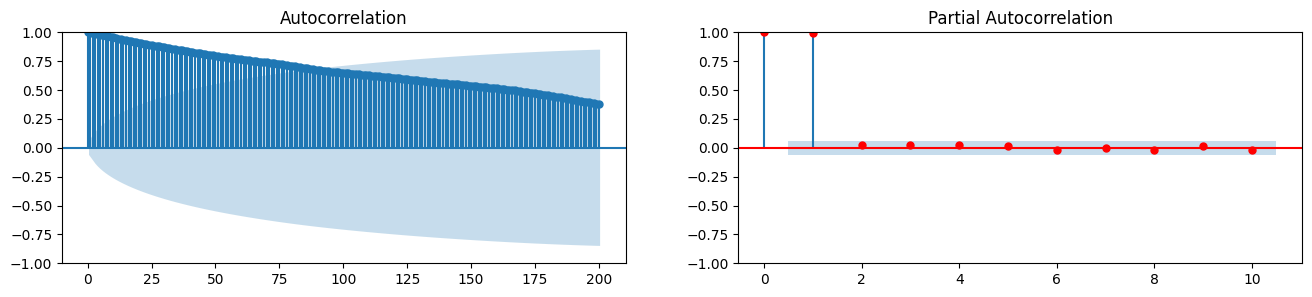

In [226]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(df_train.AAPL, lags=200, ax=axes[0]);
plot_pacf(df_train.AAPL, lags=10, ax=axes[1], color='r');

In [ ]:
# p = 1, q = 85 (ca.)

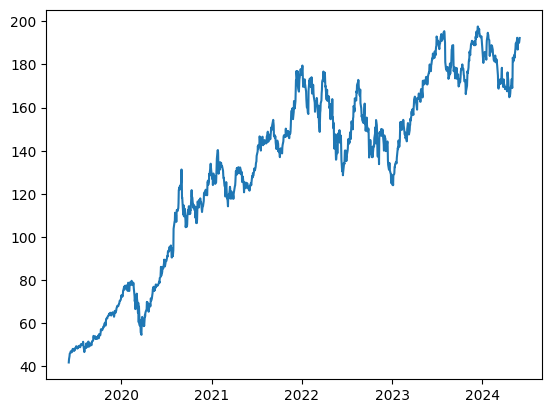

In [227]:
plt.plot(df_apple)

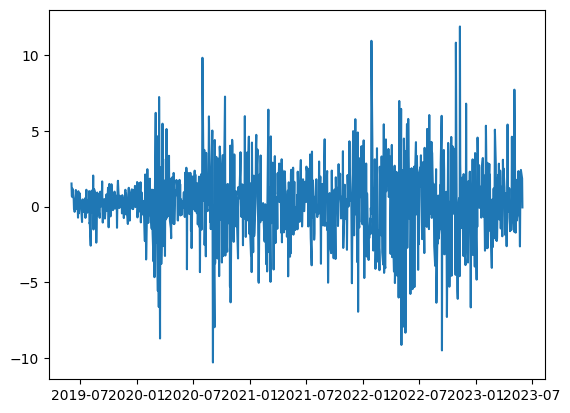

In [229]:
differenced_1 = df_train.diff()
plt.plot(differenced_1)

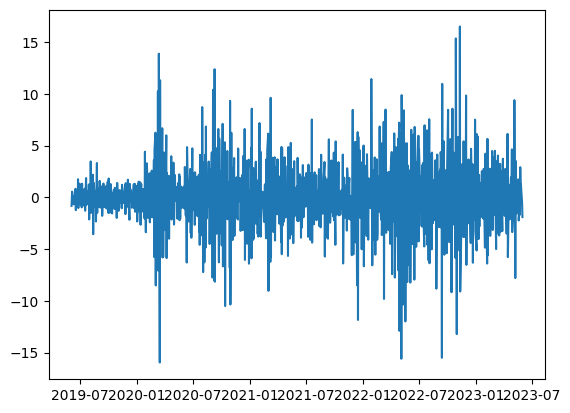

In [230]:
diff_2 = differenced_1.diff()
plt.plot(diff_2)

In [ ]:
# p = 1, q = 110 (ca.), d = 1 -> maybe 2

In [231]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(df_train)[1])
print('p-value first-diff: ', adfuller(df_train.diff().dropna())[1])
print('p-value second-diff: ', adfuller(df_train.diff().diff().dropna())[1])

p-value zero-diff:  0.5621424204120699
p-value first-diff:  0.0
p-value second-diff:  4.552356223269946e-23


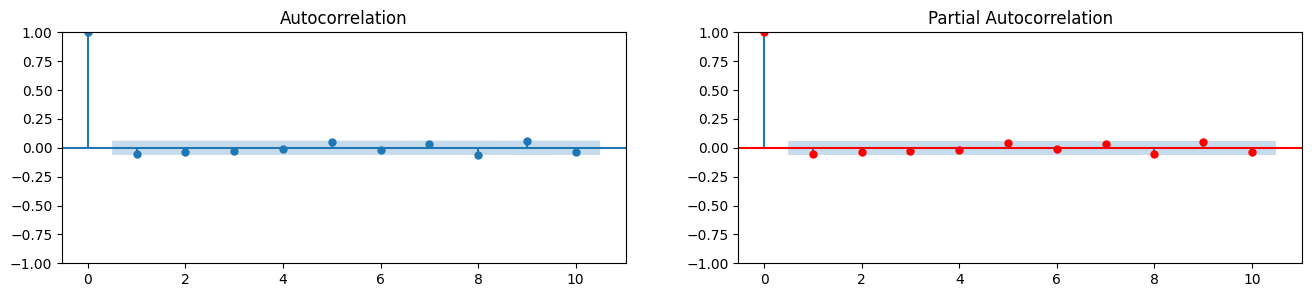

In [232]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(differenced_1.dropna().AAPL, lags=10, ax=axes[0]);
plot_pacf(differenced_1.dropna().AAPL, lags=10, ax=axes[1], color='r');

In [233]:
%%time
arima_2 = ARIMA(df_train["AAPL"], order=(0, 1, 0), trend='t')
arima_2 = arima_2.fit()
arima_2.summary()

CPU times: user 88.2 ms, sys: 6.27 ms, total: 94.5 ms
Wall time: 94.5 ms


/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                 1007
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2347.228
Date:                Mon, 03 Jun 2024   AIC                           4698.456
Time:                        14:18:23   BIC                           4708.284
Sample:                             0   HQIC                          4702.190
                               - 1007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1337      0.079      1.699      0.089      -0.021       0.288
sigma2         6.2252      0.191     32.609      0.000       5.851       6.599
===================================================================================
Ljung-Box (L1) (Q):                   3.19   Jarque-Bera (JB):               208.44
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.39   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [235]:
1259*0.8

1007.2

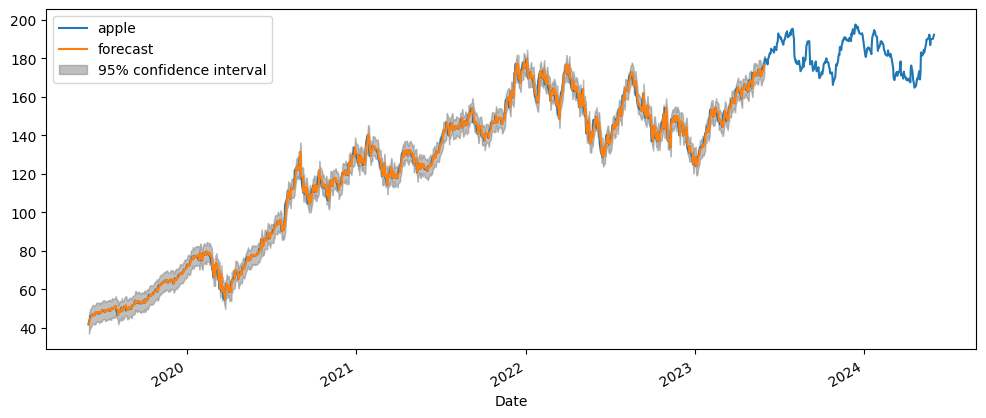

In [237]:

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(df_apple["AAPL"], label='apple')
plot_predict(arima_2, start=1, end=1006, ax=axs);

In [238]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [241]:
forecast = arima_2.forecast(len(df_test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima_2.get_forecast(len(df_test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


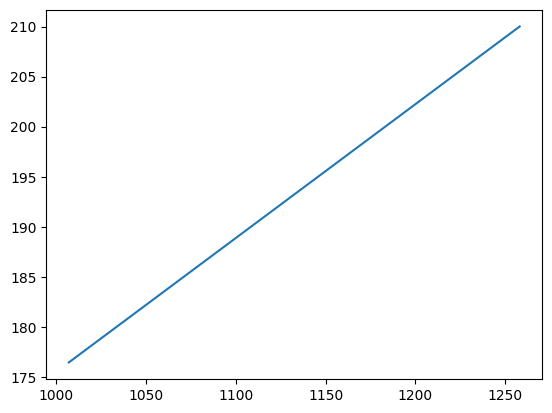

In [260]:
plt.plot(forecast)

In [268]:
forecast_df = pd.DataFrame(forecast).set_index(df_test.index)
forecast_df = forecast_df["predicted_mean"]
forecast_df


Date
2023-06-01 04:00:00    176.447338
2023-06-02 04:00:00    176.581032
2023-06-05 04:00:00    176.714725
2023-06-06 04:00:00    176.848419
2023-06-07 04:00:00    176.982112
                          ...    
2024-05-24 04:00:00    209.469655
2024-05-28 04:00:00    209.603349
2024-05-29 04:00:00    209.737043
2024-05-30 04:00:00    209.870736
2024-05-31 04:00:00    210.004430
Name: predicted_mean, Length: 252, dtype: float64

In [261]:
fc_series = pd.Series(forecast, index=df_test.index)
fc_series
#plt.plot(fc_series)

Date
2023-06-01 04:00:00   NaN
2023-06-02 04:00:00   NaN
2023-06-05 04:00:00   NaN
2023-06-06 04:00:00   NaN
2023-06-07 04:00:00   NaN
                       ..
2024-05-24 04:00:00   NaN
2024-05-28 04:00:00   NaN
2024-05-29 04:00:00   NaN
2024-05-30 04:00:00   NaN
2024-05-31 04:00:00   NaN
Name: predicted_mean, Length: 252, dtype: float64

In [263]:
df_test.index

DatetimeIndex(['2023-06-01 04:00:00', '2023-06-02 04:00:00',
               '2023-06-05 04:00:00', '2023-06-06 04:00:00',
               '2023-06-07 04:00:00', '2023-06-08 04:00:00',
               '2023-06-09 04:00:00', '2023-06-12 04:00:00',
               '2023-06-13 04:00:00', '2023-06-14 04:00:00',
               ...
               '2024-05-17 04:00:00', '2024-05-20 04:00:00',
               '2024-05-21 04:00:00', '2024-05-22 04:00:00',
               '2024-05-23 04:00:00', '2024-05-24 04:00:00',
               '2024-05-28 04:00:00', '2024-05-29 04:00:00',
               '2024-05-30 04:00:00', '2024-05-31 04:00:00'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

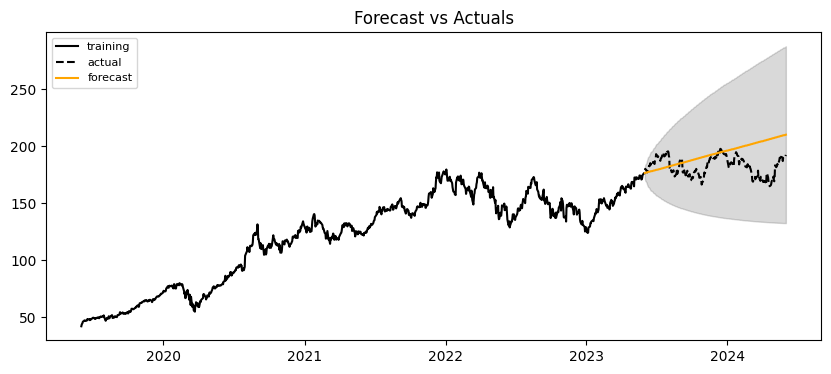

In [269]:
plot_forecast(forecast_df, df_train, df_test, confidence_int[:,0], confidence_int[:,1])

#plt.ylim(0, 500)

In [195]:
%%time
arima = ARIMA(df_apple["AAPL"], order=(1, 1, 110), trend='t')
arima = arima.fit()

/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/manonantonacci/.pyenv/versions/3.10.6/envs/project_env/lib/python3.10/site-packages/statsm

CPU times: user 3h 49min 11s, sys: 1min 25s, total: 3h 50min 36s
Wall time: 29min 53s


In [196]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                 1259
Model:               ARIMA(1, 1, 110)   Log Likelihood               -2846.596
Date:                Mon, 03 Jun 2024   AIC                           5919.192
Time:                        14:02:17   BIC                           6499.704
Sample:                             0   HQIC                          6137.357
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1160      0.037      3.138      0.002       0.044       0.188
ar.L1          0.2104      3.462      0.061      0.952      -6.576       6.996
ma.L1         -0.2335      3.461     -0.067      0.946      -7.017       6.550
ma.L2         -0.0284      0.085     -0.333      0.739      -0.196       0.139
ma.L3         -0.0103      0.117     -0.087      0.930      -0.240       0.220
ma.L4         -0.0101      0.064     -0.158      0.875      -0.136       0.116
ma.L5          0.0333      0.054      0.612      0.541      -0.073       0.140
ma.L6         -0.0237      0.107     -0.222      0.824      -0.233       0.186
ma.L7          0.0311      0.066      0.473      0.636      -0.098       0.160
ma.L8         -0.0523      0.100     -0.522      0.601      -0.249       0.144
ma.L9          0.0424      0.161      0.263      0.793      -0.273       0.358
ma.L10        -0.0187      0.116     -0.161      0.872      -0.246       0.208
ma.L11         0.0383      0.053      0.725      0.469      -0.065       0.142
ma.L12        -0.0099      0.127     -0.078      0.938      -0.259       0.239
ma.L13         0.0054      0.029      0.187      0.851      -0.051       0.062
ma.L14         0.0029      0.035      0.084      0.933      -0.065       0.071
ma.L15        -0.0200      0.034     -0.591      0.554      -0.086       0.046
ma.L16        -0.0010      0.072     -0.014      0.988      -0.143       0.141
ma.L17        -0.0482      0.035     -1.363      0.173      -0.117       0.021
ma.L18         0.0584      0.175      0.333      0.739      -0.285       0.402
ma.L19        -0.0064      0.168     -0.038      0.970      -0.336       0.323
ma.L20        -0.0046      0.033     -0.140      0.889      -0.069       0.060
ma.L21         0.0011      0.034      0.032      0.974      -0.065       0.067
ma.L22        -0.0224      0.030     -0.734      0.463      -0.082       0.037
ma.L23         0.0593      0.083      0.715      0.475      -0.103       0.222
ma.L24        -0.0434      0.194     -0.224      0.823      -0.423       0.336
ma.L25        -0.0060      0.118     -0.051      0.959      -0.237       0.225
ma.L26        -0.0234      0.055     -0.423      0.673      -0.132       0.085
ma.L27         0.0513      0.097      0.531      0.596      -0.138       0.241
ma.L28        -0.0003      0.160     -0.002      0.999      -0.313       0.312
ma.L29         0.0230      0.048      0.480      0.631      -0.071       0.117
ma.L30        -0.0420      0.093     -0.450      0.653      -0.225       0.141
ma.L31        -0.0079      0.132     -0.060      0.952      -0.267       0.251
ma.L32         0.0020      0.061      0.033      0.974      -0.118       0.122
ma.L33        -0.0856      0.033     -2.609      0.009      -0.150      -0.021
ma.L34         0.0348      0.298      0.117      0.907      -0.550       0.619
ma.L35         0.0090      0.067      0.135      0.893      -0.122       0.141
ma.L36        -0.0090      0.051     -0.178      0.859      -0.108       0.090
ma

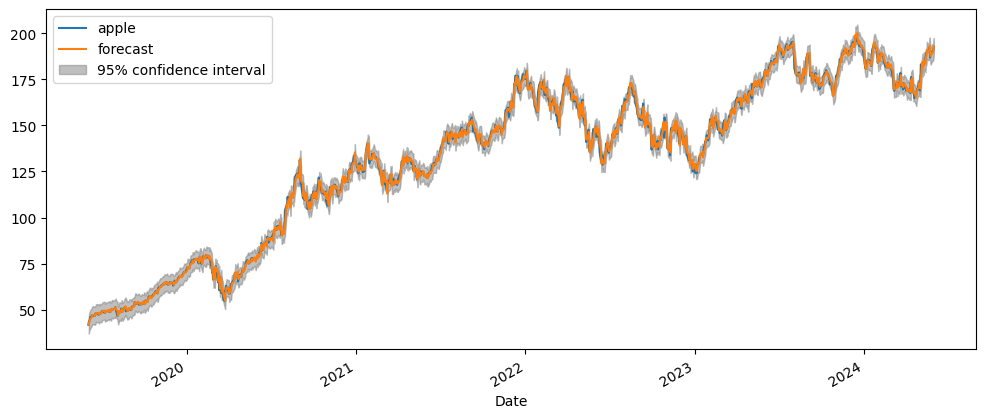

In [202]:

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(df_apple["AAPL"], label='apple')
plot_predict(arima, start=1, end=1258, ax=axs);